#### CMSE 202 Final Project
### &#9989; Chris Brown, Kewalin Samart, Jay Scott, Raymond Smith
### &#9989; Section_003
#### &#9989; 4/13/21

# ___Modeling Oxygen Repopulation in Blood Cells___

## Background and Motivation

Adenosine Triphosphate (ATP) is one of the main compounds in our body that the cells use to store and release energy. Oxygen is essential for ATP production in the Krebs cycle. Without oxygen, our body cannot make any energy, and insufficient oxygen intake reduces metabolism efficiency. In the respiratory process, we take in oxygen and take out unnecessary gases e.g. carbon dioxide, by breathing. About 97% of the oxygen is transported throughout the body by hemoglobins in the red blood cells, and the rest is dissolved in plasma. One hemoglobin has a minimum capacity of one oxygen molecule and a maximum capacity of four oxygen molecules. Hemoglobins carry oxygen molecules and drop them off at the target cells in organ tissues. As a waste of the Krebs cycle, carbon dioxide is picked up by the hemoglobin and transported to the lung in order to be released through the gas exchange process. To obtain a better understanding of this important biological mechanism. We, therefore, develop an agent-based model to demonstrate how blood cells repopulate oxygen in the body. The model focuses on showing the big picture of how red blood cells as carriers of oxygen and carbon dioxide move around the body through veins and arteries.

## Methodology

### Pseudocode

__*Focusing on modeling blood moving through veins/arteries.*__

1) Initialize a board- Put oxygen, blood cells, and organs on the board. Veins/arteries represented by straight line boundaries on board. Put veins and arteries on the board with junctions. Organs should occupy multiple grid points and be initialized containing CO2

2) Use classes to represent oxygen, blood cell/hemoglobin, and organs.

    Attributes/Methods
    
    Oxygen; Able to be transferred from blood to organs. (For smaller model)Oxygen is able to diffuse from lungs to blood stream. Oxygen randomly appears every few time steps to represent breathing. Most oxygen must be carried by blood cells/hemoglobin. A percentage of oxygen dissolves/diffuses into plasma which contains blood cells. 3% of oxygen will be randomly chosen to move randomly through plasma alongside blood cells.
    
    Blood Cells/Hemoglobin; Randomly assign blood cells at start to have oxygen or CO2. Blood cells have two different states, full of oxygen and full of CO2. Moves radomly through veins and arteries, at junctions we can set different probabilities for which path a blood cell might take. Blood cells check every grid point around them (nearest neighbor function) for vein/artery paths. Blood cells carrying CO2 only travel through veins and cells carrying oxygen only travel through arteries.
    
    Organs; Organs contain CO2 when initialized with the board. Absorb oxygen and create CO2. When oxygen reaches an organ it is turned into CO2 and leaves the organ. When CO2 reaches the lungs we somehow show it being expelled from the body (it disappears from the model)



### Code

In [1]:
#All of the imports
import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, clear_output
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from Board_Class import *
from Blood_Cell_Class import *
from General_O2_CO2_Class import *

In [3]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', \
                            frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

In [4]:
board = np.zeros(shape = (250,200)) # Initializing a 250 by 200 size board of color purple

# heart
board[70:100,75:100] = 1 # left part of the heart (low oxygen; blue)
board[70:100,100:130] = 2 # right part of the heart (high oxygen; teal; anatomically bigger than the left part)

# lung 
board[5:40,70:135] = 3

# organ no.1 
board[140:160,80:120] = 4

# organ no.2
board[170:190,80:120] = 5

# organ no.3
board[200:220,80:120] = 6

# veins; blue
board[40:70,80:90] = 1 # vein connecting lung and left part of the heart
board[80:90,25:75] = 1 # top vein connecting lung with organs
board[90:215,25:35] = 1 # side vein connecting lung with organs
board[145:155,35:80] = 1 # side vein organ no.1
board[175:185,35:80] = 1 # side vein organ no.2
board[205:215,35:80] = 1 # side vein organ no.3

# arteries; teal
board[40:70,115:125] = 2 # artery connecting lung and right part of the heart
board[80:90,130:180] = 2 # top artery connecting lung with organs
board[90:215,170:180] = 2 # side artery connecting lung with organs
board[145:155,120:170] = 2 # side artery organ no.1
board[175:185,120:170] = 2 # side artery organ no.2
board[205:215,120:170] = 2 # side artery organ no.3

In [5]:
def simulation(cells):
    '''
    Object Movement
    '''

    fig, ax = plt.subplots(figsize=(10,5))
    
    for _ in range(10000):
        
        for b in cells:
    
            location = b.board_location()
                
            # movement conditions based on coordinates
            if location[1] < 86 and location[0] > 150:
                b.movement_down()
                b.transfer()
                b.draw()
        
            elif (30 <= location[0] < 86) and location[1] <= 86: 
                b.movement_right()
                b.transfer()
                b.draw()
        
            elif location[1] == 20 and location[0] == 86:
                b.movement_right()
                b.transfer()
                b.draw()
        
            elif 20 <= location[1] <=30 and location[0] >= 86 and location[0] != 120:
                b.movement_right()
                b.transfer()
                b.draw()
        
            elif location[1] <= 40 and location[0] == 120:
                b.movement_down()
                b.transfer()
                b.draw()
        
            elif location[0] == 86 and location[1] <= 86:
                b.movement_up()
                b.transfer()
                b.draw()
   
            elif location[0] == 30:
                b.movement_up()
                b.transfer()
                b.draw()

            elif location[0] < 176 and location[1] == 86:
                b.movement_right()
                b.transfer()
                b.draw()
                
            elif location[0] == 176 and location[1] < 150: 
                b.movement_down()
                b.transfer()
                b.draw()
            
            elif location[0] == 176 and location[1] == 150: #Potentially enter organ 1
                prob = random.random()
                if prob > 0.33:
                    b.movement_down()
                    b.transfer()
                    b.draw()
                else:
                    b.movement_left()
                    b.transfer()
                    b.draw()
                
            elif location[0] == 30 and location[1] == 150:
                b.movement_up()
                b.transfer()
                b.draw()
            
            elif location[1] == 150:
                b.movement_left()
                b.transfer()
                b.draw()  
        
            elif 40 < location[1] < 180: #Potentially enter organ 2 
                b.movement_down()
                b.transfer()
                b.draw()
        
            elif location[0] == 176 and location[1] == 180:
                prob = random.random()
                if prob > 0.33:
                    b.movement_down()
                    b.transfer()
                    b.draw()
                else:
                    b.movement_left()
                    b.transfer()
                    b.draw()
                    
            elif location[0] == 30 and location[1] == 180:
                b.movement_up()
                b.transfer()
                b.draw()

            elif location[1] == 180:
                b.movement_left()
                b.transfer()
                b.draw()  
    
            elif 40 < location[1] < 210: #Potentially enter organ 3 
                b.movement_down()
                b.transfer()
                b.draw()

            elif location[0] == 30 and location[1] == 210:
                b.movement_up()
                b.transfer()
                b.draw()

            elif location[1] == 210:
                b.movement_left()
                b.transfer()
                b.draw()  
    
    
        # Animaiton part (dosn't change)
        plt.imshow(board)
        image_path = 'The_heart.jfif'
        the_image = 'The_lungs.jpg'
        imscatter(102, 90, image_path, zoom=0.165)
        imscatter(102, 21, the_image, zoom=0.275)
        clear_output(wait=True) # Clear output for dynamic display
        display(fig)            # Reset display
        fig.clear()             # Prevent overlapping and layered plots
        time.sleep(0.0001)      # Sleep for a fraction of a second to allow animation to catch up
        # Sleep for a fraction of a second to allow animation to catch up
        

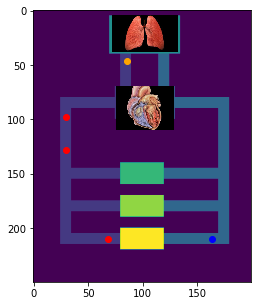

In [ ]:
# Running the simulation of a red blood cell
coords = [[100,26], [100,150], [100,180], [100,210]]
coords2 = [[116,86], [86,86]]
cells = []

b_cells = []
o_cells = []

for c in coords: 
    b = blood_cell(c)
    b_cells.append(b)
    
for c2 in coords2: 
    o = oxygen_carbon_dioxide(c2)
    o_cells.append(o)
    
cells.extend(b_cells)
cells.extend(o_cells)

simulation(cells)

## Discussion

Things we could have done with more time:
- Shown changes in blood pressure in the model by changing the number of units that each blood cell moves when traveling through certain areas on the board


## References

- https://www.ch.ic.ac.uk/rzepa/mim/environmental/html/oxygen.htm
- https://www.youtube.com/watch?v=zwbj866zkL8
- https://openoregon.pressbooks.pub/mhccbiology101/chapter/citric-acid-cycle/
- Image of heart: https://qph.fs.quoracdn.net/main-qimg-442bcce157dc039bb52328c0af5dd2b2-c
- Image of lungs: https://www.drugabuse.gov/sites/default/files/2020-05/lungs_flickr_wesley_mccormick_6809216382.jpg